Author: Darian Hadjiabadi
CS 231N final project

Now that the granule cell DCGAN models have been trained and stored, we can actually look
at generated granule cell dendritic arborizations. This notebook will first visualize and plot the weight distributions
for the discriminator and generator convolutional layers. Then, we will generate dendritic arborizations and quantify each model using the kernel maximum mean discrepency metric

In [1]:
# Run this

import numpy as np
import sys
import os

import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

from gan.network_utils import run_a_gan
from gan.network_utils import show_images
from gan.network_utils import initialize_weights
from gan.network_utils import gan_generate
from gan.network_utils import count_params
from gan.network_utils import save_model
from gan.network_utils import load_model
from gan.network import discriminator
from gan.network import dc_discriminator
from gan.network import vanilla_discriminator_loss
from gan.network import ls_discriminator_loss
from gan.network import generator
from gan.network import dc_generator
from gan.network import vanilla_generator_loss
from gan.network import ls_generator_loss
from gan.network import get_optimizer
import scipy.ndimage

import gan.kernel_mmd as mmd



import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)




In [2]:
# run this if you want to save images 
def count_to_str(count):
    if count < 10:
        return '00000' + str(count)
    elif count >= 10 and count < 100:
        return '0000' + str(count)
    elif count >= 100 and count < 1000:
        return '000' + str(count)
    elif count >= 1000 and count < 10000:
        return '00' + str(count)
    elif count >= 10000 and count < 100000:
        return '0' + str(count)
    
def save_imgs(imgs, dir_path):
    import scipy.misc
    imgs = np.reshape(imgs, [imgs.shape[0], -1])
    sqrtimg = int(np.ceil(np.sqrt(imgs.shape[1])))
    imgs = np.reshape(imgs, (imgs.shape[0], sqrtimg, sqrtimg))
    
    for i in range(imgs.shape[0]):
        nstr = count_to_str(i)
        fn_full = 'img-' + nstr + '.png'
        scipy.misc.imsave(dir_path + fn_full, imgs[i,:,:])        


In [3]:
# Run this

batch_size = 64
dtype = torch.cuda.FloatTensor
directory = 'models/granule/'

In [5]:
# Run this. This cell will load in 4 granule cell generators trained over ~ 4000 iterations.

G_ls_0_in_0 = dc_generator(batch_size).type(dtype)
G_ls_0_in_1 = dc_generator(batch_size).type(dtype)
G_ls_1_in_0 = dc_generator(batch_size).type(dtype)
G_ls_1_in_1 = dc_generator(batch_size).type(dtype)


load_model(G_ls_0_in_0, directory + 'trained-granule-generator-ls-0-in-0.pt')
load_model(G_ls_0_in_1, directory + 'trained-granule-generator-ls-0-in-1.pt')
load_model(G_ls_1_in_0, directory + 'trained-granule-generator-ls-1-in-0.pt')
load_model(G_ls_1_in_1, directory + 'trained-granule-generator-ls-1-in-1.pt')

print(G_ls_0_in_0)
print(count_params(G_ls_0_in_0))
for p in G_ls_0_in_0.parameters():
    print(p.size())

Sequential(
  (0): Linear(in_features=96, out_features=1024, bias=True)
  (1): ReLU(inplace)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1024, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Unflatten()
  (7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (8): ReLU(inplace)
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (11): ReLU(inplace)
  (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (14): ReLU(inplace)
  (15): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): ConvTranspose2d(8, 1, kernel_size=(3, 3), str

In [5]:
# Run this. This cell will load in 4 granule cell discriminators trained over ~ 4000 iterations.

D_ls_0_in_0 = dc_discriminator(batch_size).type(dtype)
D_ls_0_in_1 = dc_discriminator(batch_size).type(dtype)
D_ls_1_in_0 = dc_discriminator(batch_size).type(dtype)
D_ls_1_in_1 = dc_discriminator(batch_size).type(dtype)


load_model(D_ls_0_in_0, directory + 'trained-granule-discriminator-ls-0-in-0.pt')
load_model(D_ls_0_in_1, directory + 'trained-granule-discriminator-ls-0-in-1.pt')
load_model(D_ls_1_in_0, directory + 'trained-granule-discriminator-ls-1-in-0.pt')
load_model(D_ls_1_in_1, directory + 'trained-granule-discriminator-ls-1-in-1.pt')

print(D_ls_0_in_0)
print(count_params(D_ls_0_in_0))

for p in D_ls_0_in_0.parameters():
    print(p.size())

Sequential(
  (0): Unflatten()
  (1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (2): LeakyReLU(negative_slope=0.01, inplace)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (5): LeakyReLU(negative_slope=0.01, inplace)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 64, kernel_size=(6, 6), stride=(1, 1))
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten()
  (10): Linear(in_features=1024, out_features=1024, bias=True)
  (11): LeakyReLU(negative_slope=0.01, inplace)
  (12): Linear(in_features=1024, out_features=1, bias=True)
)
torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([64, 64, 6, 6])
torch.Size([64])
torch.Size([1024, 1024])
torch.Size([1024])
torch.Size([1, 1024])
torch.Size([1])


Next few cells will aim to visualize and plot weight distributions for the discriminator and generator conv layers

In [6]:
def resample_image(imgs, zoom=2, order=1):
    N,H,W = imgs.shape
    new_images = np.zeros((N,zoom*H,zoom*W))
    for i in range(N):
        new_images[i,:,:] = scipy.ndimage.zoom(imgs[i,:,:],zoom,order=order)
    return new_images


def visualize_parameters(model, stop, zoom=2, order=2, mode='gan'):
    filters, mfilters = None, None
    params = model.parameters()
    count = 1
    for p in params:
        tensor_shape = list(p.size())
        if len(tensor_shape) == 4:
            if count == stop:
                filters = p.data.cpu().numpy()
                break
            count += 1
    if filters is not None:
        if mode == 'gan':
            mfilters = np.mean(filters,axis=0)
        elif mode == 'disc':
            mfilters = np.mean(filters,axis=1)
        mfilters_showcase = resample_image(mfilters,zoom=zoom,order=order)
        show_images(mfilters_showcase)
        return filters

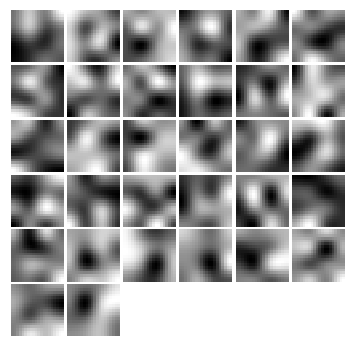

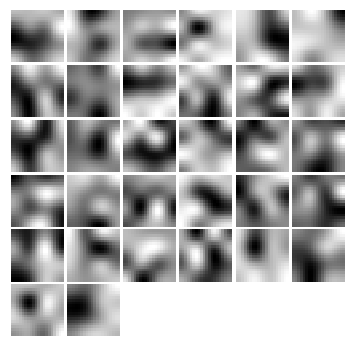

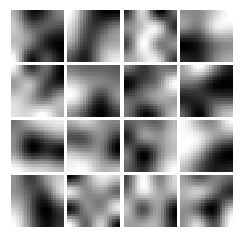

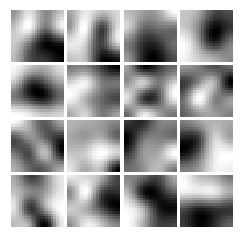

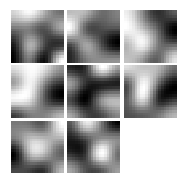

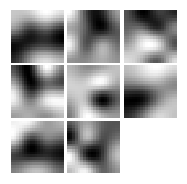

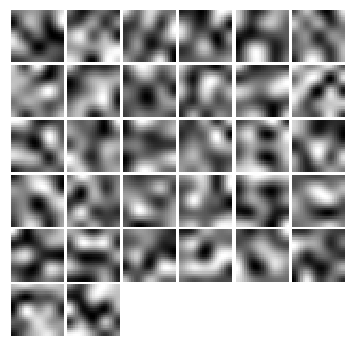

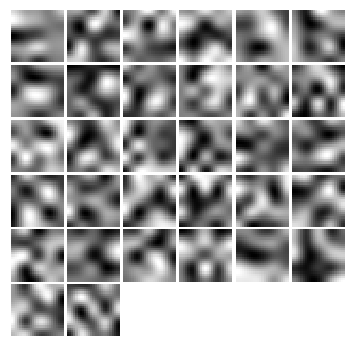

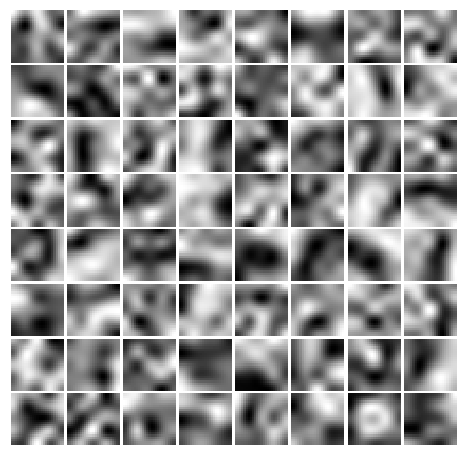

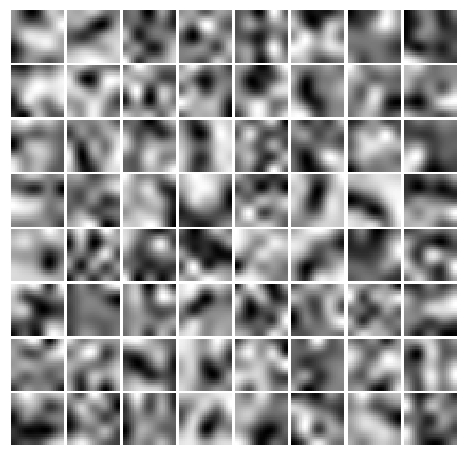

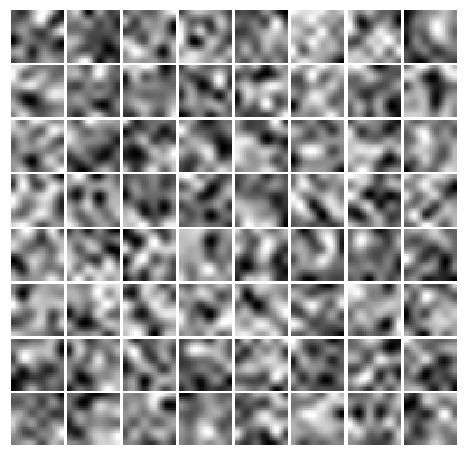

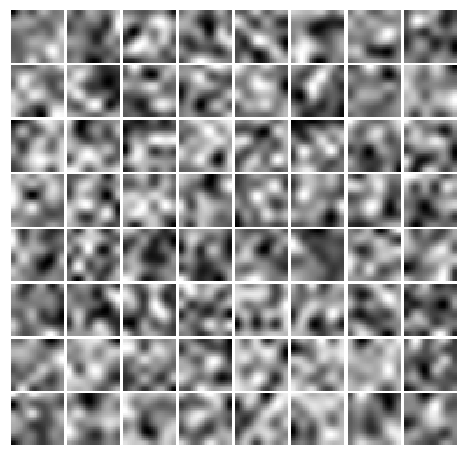

In [7]:
filters_gn1 = visualize_parameters(G_ls_0_in_0, 1, zoom=5, order=3, mode='gan')
filters_gs1 = visualize_parameters(G_ls_1_in_1, 1, zoom=5, order=3, mode='gan')

filters_gn2 = visualize_parameters(G_ls_0_in_0, 2, zoom=5, order=3, mode='gan')
filters_gs2 = visualize_parameters(G_ls_1_in_1, 2, zoom=5, order=3, mode='gan')

filters_gn3 = visualize_parameters(G_ls_0_in_0, 3, zoom=5, order=3, mode='gan')
filters_gs3 = visualize_parameters(G_ls_1_in_1, 3, zoom=5, order=3, mode='gan')

filters_dn1 = visualize_parameters(D_ls_0_in_0, 1, zoom=5, order=3, mode='disc')
filters_ds1 = visualize_parameters(D_ls_1_in_1, 1, zoom=5, order=3, mode='disc')

filters_dn2 = visualize_parameters(D_ls_0_in_0, 2, zoom=5, order=3, mode='disc')
filters_ds2 = visualize_parameters(D_ls_1_in_1, 2, zoom=5, order=3, mode='disc')

filters_dn3 = visualize_parameters(D_ls_0_in_0, 3, zoom=5, order=3, mode='disc')
filters_ds3 = visualize_parameters(D_ls_1_in_1, 3, zoom=5, order=3, mode='disc')


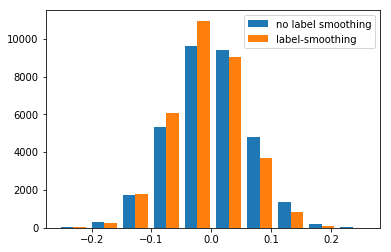

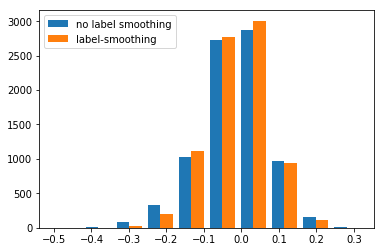

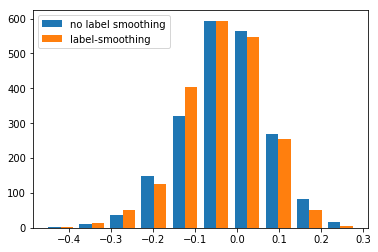

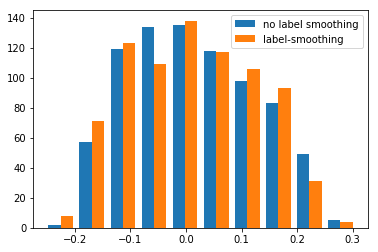

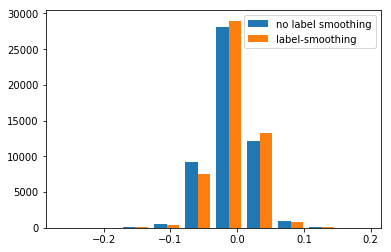

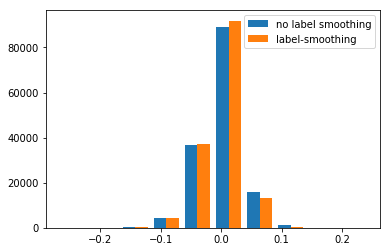

In [8]:
# Plot pixel value histograms for the convolutional layr weights extracted in the previous section.
# Each distribution is acquired from the mean image of each layer

plt.figure()
plt.hist([filters_gn1.reshape(-1,), filters_gs1.reshape(-1,)])
plt.legend(['no label smoothing', 'label-smoothing'])
plt.figure()
plt.hist([filters_gn2.reshape(-1,), filters_gs2.reshape(-1,)])
plt.legend(['no label smoothing', 'label-smoothing'])
plt.figure()
plt.hist([filters_gn3.reshape(-1,), filters_gs3.reshape(-1,)])
plt.legend(['no label smoothing', 'label-smoothing'])
plt.figure()
plt.hist([filters_dn1.reshape(-1,), filters_ds1.reshape(-1,)])
plt.legend(['no label smoothing', 'label-smoothing'])
plt.figure()
plt.hist([filters_dn2.reshape(-1,), filters_ds2.reshape(-1,)])
plt.legend(['no label smoothing', 'label-smoothing'])
plt.figure()
plt.hist([filters_dn3.reshape(-1,), filters_ds3.reshape(-1,)])
plt.legend(['no label smoothing', 'label-smoothing'])

Let's generate synthetic morphologies using the generator models!

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


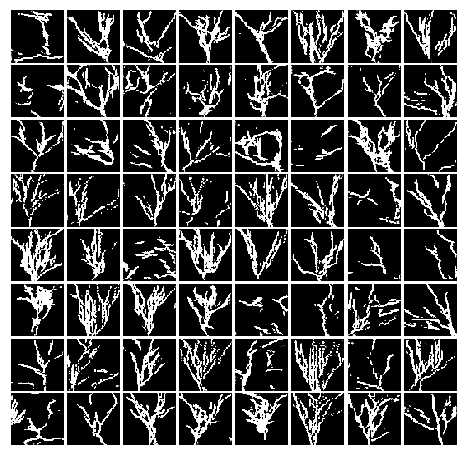

In [6]:
# Instance noise off / label smoothing off
fake_imgs = gan_generate(dtype, G_ls_0_in_0)
show_images(fake_imgs)

output_dir = 'output-large/granule/no-label-smoothing/' # change output directory to location of preferences
save_imgs(fake_imgs, output_dir) # comment out if you do not want to save

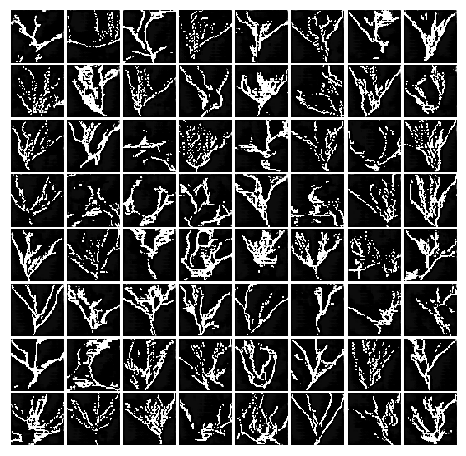

In [5]:
# Instance noise on / label smoothing off
fake_imgs = gan_generate(dtype, G_ls_0_in_1)
show_images(fake_imgs)

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


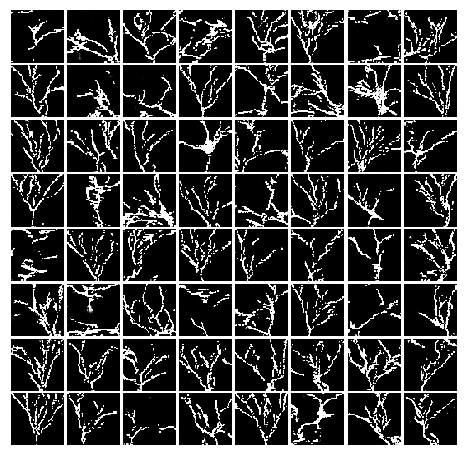

In [7]:
# Instance noise off / label smoothing on

fake_imgs = gan_generate(dtype, G_ls_1_in_0)
show_images(fake_imgs)


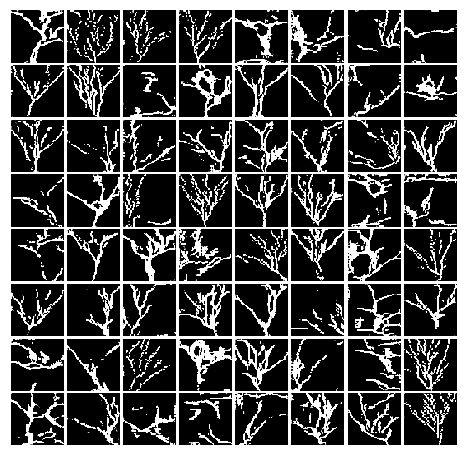

In [9]:
# Instance noise on / label smoothing on

fake_imgs = gan_generate(dtype, G_ls_1_in_1)
show_images(fake_imgs)

output_dir = 'output-large/granule/label-smoothing/' # change output directory to location of preferences
save_imgs(fake_imgs, output_dir) # comment out if you do not want to save

Now that we have visualized synthetic morphologies, I want to use kernal maximum mean discrepancy to quantify each model.

In [9]:
from scipy import misc
import glob
import time

batch_size, img_size = 64, 64


def read_imgs(dir_fn):
    imgs = np.zeros((10000,img_size,img_size))
    count = 0
    for image_path in glob.glob(dir_fn + '*.png'):
        image = misc.imread(image_path)
        imgs[count, :, :] = image
        count += 1
    return imgs[0:count,:,:]

def fake_img_collection(model, N_real):
    
    fake_imgs = np.zeros((N_real, img_size*img_size))
    fake_count, img_count = 0, 0
    while fake_count < N_real:
        batch_fake =  gan_generate(dtype, model)
        for i in range(batch_fake.shape[0]):
            if img_count < N_real:
                fake_imgs[img_count,:] = batch_fake[i,:]
                img_count += 1
        fake_count += batch_fake.shape[0] 
    return fake_imgs


In [10]:

real_testing_dir = 'database-imgs-full/granule/train/a/'
real_imgs = read_imgs(real_testing_dir)
real_imgs /= 255
np.random.shuffle(real_imgs)
N_real = real_imgs.shape[0]

fake_imgs_ls_0_in_0 = fake_img_collection(G_ls_0_in_0, N_real)
fake_imgs_ls_0_in_1 = fake_img_collection(G_ls_0_in_1, N_real)
fake_imgs_ls_1_in_0 = fake_img_collection(G_ls_1_in_0, N_real)
fake_imgs_ls_1_in_1 = fake_img_collection(G_ls_1_in_1, N_real)

fake_imgs_ls_0_in_0[fake_imgs_ls_0_in_0 < 0.0] = 0.0
fake_imgs_ls_0_in_1[fake_imgs_ls_0_in_1 < 0.0] = 0.0
fake_imgs_ls_1_in_0[fake_imgs_ls_1_in_0 < 0.0] = 0.0
fake_imgs_ls_1_in_1[fake_imgs_ls_1_in_1 < 0.0] = 0.0

print(real_imgs.shape)
print(fake_imgs_ls_0_in_0.shape)
print(fake_imgs_ls_0_in_1.shape)
print(fake_imgs_ls_1_in_0.shape)
print(fake_imgs_ls_1_in_1.shape)



/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':


(2738, 64, 64)
(2738, 4096)
(2738, 4096)
(2738, 4096)
(2738, 4096)


In [14]:
sigmas = 10 ** np.random.uniform(0,2,10)
sigmas_sorted = np.sort(sigmas)

ls_0_in_0, ls_0_in_1, ls_1_in_0, ls_1_in_1 = [], [], [], []

for sigma in sigmas_sorted:
    
    print(sigma)
    
    ls_0_in_0.append(mmd.mmd(real_imgs[0:256,:,:], fake_imgs_ls_0_in_0[0:256,:], sigma))
    ls_0_in_1.append(mmd.mmd(real_imgs[0:256,:,:], fake_imgs_ls_0_in_1[0:256,:], sigma))
    ls_1_in_0.append(mmd.mmd(real_imgs[0:256,:,:], fake_imgs_ls_1_in_0[0:256,:], sigma))
    ls_1_in_1.append(mmd.mmd(real_imgs[0:256,:,:], fake_imgs_ls_1_in_1[0:256,:], sigma))
print('done')

1.0227140515261888
3.4370387495777246
4.79890815158416
6.006201543475382
8.495330146387547
9.120914730348757
19.89422800325978
22.6094457580841
40.754217411071565
71.54356435512004
done


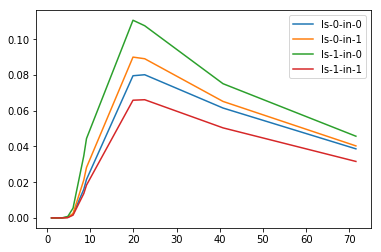

In [15]:
plt.figure()
plt.plot(sigmas_sorted, ls_0_in_0)
plt.plot(sigmas_sorted, ls_0_in_1)
plt.plot(sigmas_sorted, ls_1_in_0)
plt.plot(sigmas_sorted, ls_1_in_1)
plt.legend(['ls-0-in-0', 'ls-0-in-1', 'ls-1-in-0', 'ls-1-in-1'])
plt.show()
